In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.stats import t
from scipy.stats import mannwhitneyu
import statsmodels.stats.power as smp
import numpy as np

## 1) Ваш продукт - это школа английского языка Лендинг для языковой школы [Лендинг для языковой школы](https://english22.tilda.ws/). 
Проанализируйте конкурентов на рынке (SkyEng, Lingvoleo и прочие) и сформулируйте гипотезу по улучшению первого экрана лендинг. 


Я провела сранительный анализ сайтов [SkyEng и Lingvole](https://www.similarweb.com/website/skyeng.ru/vs/lingualeo.com/#ranking)
Здесь можно увидеть сравнительную статистику по количеству пользователей, странам, трафику, устройствам и многое другое. Српснить с нашим ландингом, к сожалению не могу, так как www.similarweb.com его не знает. Но если бы он был реальным, мы бы сравнили на этом ресурсе и наш сайт с другими конкурентами и увидели его провалы и особенности в той или иной области.


Основные гипотезы (не смогла выбрать одну):
    1. Если на сайт добавить меню по всему сайту, мы уменьшим показатель отказа на 15%, так как пользователя будет проще пользоваться сайтом.
    2.Если на сайт добавить наши преимущества / акции, мы увеличим конверсию в запрос на 10%, так как пользователь сразу увидит интересующие его опции.
    3.Если поменять цветовую гамму сайта (да и сам рисунок), мы уменьшим процент отказа на 5%, так как подберем более читаемый цвет текста на фоне красивой картинки.
    

## 2) Подведите результаты эксперимента в экселе по следующим данным
ab_stats.csv - Google Диск: Стат значимо ли отличается ARPPU в двух группах ? Какие рекомендации дадите менеджеру?

ARPPU (англ. Average revenue per paying user) — это метрика, которая показывает среднюю прибыль от одного платящего пользователя за определенный период времени. 

In [96]:
data = pd.read_csv('C:/GB/Analyst/FinalTest/2/ab_stats.csv',  encoding='1251')
data

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
...,...,...,...,...,...
23647,0.0,0,0,B,10.207152
23648,0.0,0,0,B,5.148761
23649,0.0,0,0,B,4.809019
23650,0.0,0,0,B,8.127488


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [170]:
data_group = data \
                .groupby('ab_group', as_index=False) \
                .agg({'num_purchases': 'count', 'revenue': 'sum'})

data_group

,ab_group,num_purchases,revenue
0,A,11835,4786.807972
1,B,11817,2892.735789


Данные корректные, ненулевые, с правильными типами. Количество пользователей в группах примерно одинаковое. Разделим данные на две группы согласно принадлежности к группе A или B. Так как нас интересует метрика ARPPU (англ. Average revenue per paying user), которая показывает среднюю прибыль от одного платящего пользователя за определенный период времени, сразу возьмеме только пользователей, совершивших покупку.

In [104]:
data_A = data[(data.ab_group == 'A') & (data.purchase == 1)]
data_A.describe()

,revenue,num_purchases,purchase,av_site visit
count,256.000000,256.000000,256.0,256.000000
mean,18.698469,2.343750,1.0,6.753074
std,87.527589,9.723582,0.0,2.043753
min,0.259689,1.000000,1.0,0.996753
25%,2.318301,1.000000,1.0,5.281247
50%,4.283160,1.000000,1.0,6.871241
75%,11.923141,2.000000,1.0,8.257506
max,1303.609284,152.000000,1.0,12.504262


In [105]:
data_B = data[(data.ab_group == 'B') & (data.purchase == 1)]
data_B.describe()

,revenue,num_purchases,purchase,av_site visit
count,234.000000,234.000000,234.0,234.000000
mean,12.362119,1.841880,1.0,6.844776
std,19.007065,2.354021,0.0,3.970112
min,0.259373,1.000000,1.0,-5.646523
25%,2.319883,1.000000,1.0,4.009016
50%,3.980000,1.000000,1.0,7.143956
75%,12.274829,2.000000,1.0,9.776519
max,113.830000,25.000000,1.0,16.955948


Сделаем предварительный анализ данных и посмотрим выбросы:

<Axes: xlabel='ab_group', ylabel='revenue'>

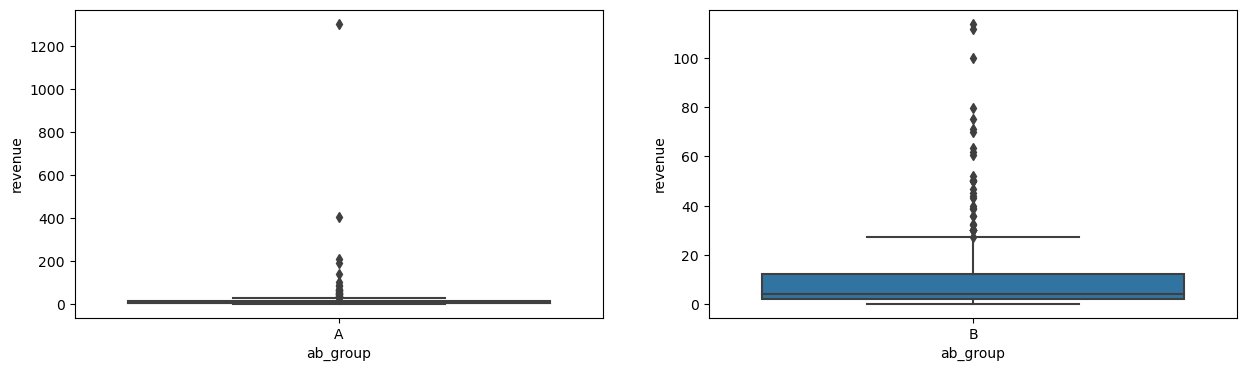

In [113]:
fig, (ax_boxplot, bx_boxplot) = plt.subplots(1, 2, figsize=(15,4))
sns.boxplot(x=data_A.ab_group, y=data_A.revenue, ax=ax_boxplot)
sns.boxplot(x=data_B.ab_group, y=data_B.revenue)

В группе А уберем выброс

In [123]:
data_A99 = data_A[data_A.revenue < data_A.revenue.quantile(0.99)]


<Axes: xlabel='ab_group', ylabel='revenue'>

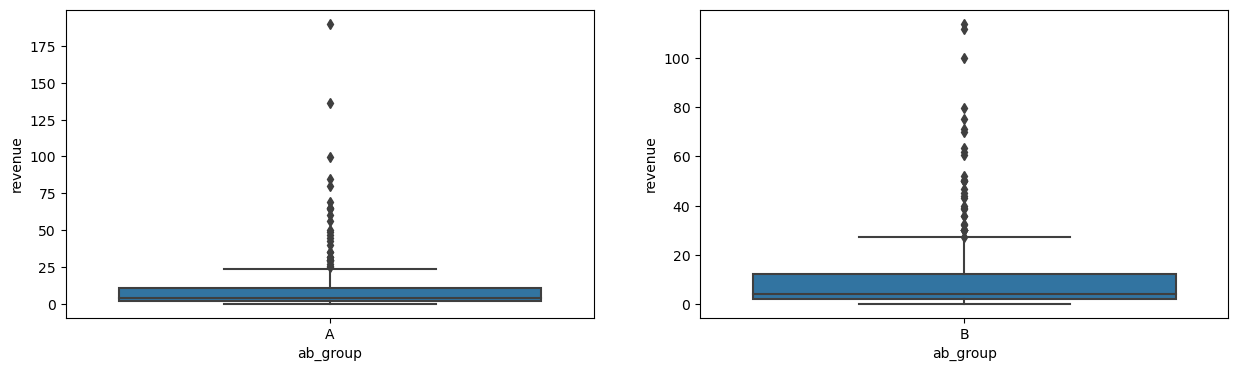

In [124]:
fig, (ax_boxplot, bx_boxplot) = plt.subplots(1, 2, figsize=(15,4))
sns.boxplot(x=data_A99.ab_group, y=data_A99.revenue, ax=ax_boxplot)
sns.boxplot(x=data_B.ab_group, y=data_B.revenue)

<Axes: xlabel='revenue', ylabel='Count'>

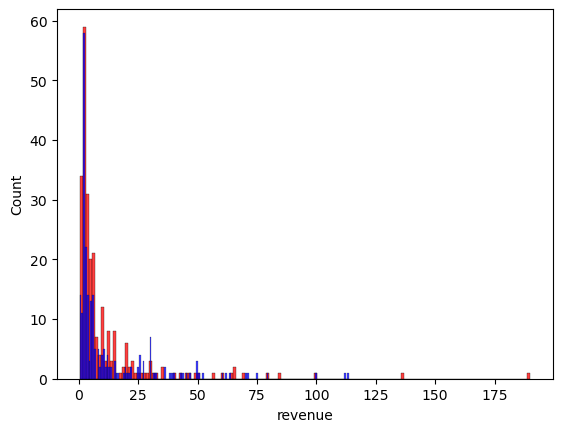

In [125]:
sns.histplot(data_A99['revenue'], color='r', bins =150)
sns.histplot(data_B['revenue'], color='b', bins =150)

Теперь данные имеют одинаковый порядок величин, что говорит о возможности их сравнительного анализа. По гистограмме видим, что данные распределены ненормально, подтвердим это критериаем Колмогорова-Смирнова:

In [134]:
print(kstest(data_A.revenue, 'norm'))
print(kstest(data_B.revenue, 'norm'))

KstestResult(statistic=0.8312038740127529, pvalue=5.535202851866456e-197, statistic_location=1.9727, statistic_sign=-1)
KstestResult(statistic=0.8635160979681316, pvalue=1.877582850318655e-202, statistic_location=1.953625, statistic_sign=-1)


Видим, что pvalue значительно меньше уровня значимости в 0,05 %, что подтверждает ненормальное распредение значений. Так как ARPPU величина количественная, распределение ненормальное, выборки независимые и их 2 - используем критерий Манна Уитни для опредения статистической значимой разницы между группами:

In [137]:
mannwhitneyu(data_A.revenue, data_B.revenue)

MannwhitneyuResult(statistic=29729.5, pvalue=0.8871956616344514)

Значение pvalue=0.887 говорит об отсутствии значимых различий между выборками для любого уровня значимости. Посчитаем мощность теста:

In [146]:
mean_A=data_A.revenue.mean()
mean_B=data_B.revenue.mean()
std_A=data_A.revenue.std()
std_B=data_B.revenue.std()
S=((std_A**2+std_B**2)/2)**0.5
n=min(data_A.shape[0], data_B.shape[0]) #так как размеры выборок почти одинакове, возьмем минимальный
ef_size=float((mean_A-mean_B)/S)
print (f'Размер эффекта {ef_size}')

Размер эффекта 0.10004684904229803


In [147]:
# видим что размер эффекта мал, посомтрим мощность теста
power=smp.zt_ind_solve_power(effect_size=ef_size, nobs1=n, alpha=0.05, alternative='two-sided')
print (f'Мощность теста {power}')

Мощность теста 0.19120287172590156


Мощность теста получаем всего 19%. Эта величина отвечает на вопрос: если нулевая гипотеза в действительности не верна, с какой вероятностью мы сможем отклонить ее в нашем эксперименте (т.е. с нашими параметрами). Такая маленькая мощность логична в следствии очень маленькой разницы средних значений и маленького размера эффекта. Что бы определить такой незначительный эффект как статистически значимый, нужно очень больший размер выборки. Посчитаем его:

In [159]:
number=smp.zt_ind_solve_power(effect_size=ef_size, alpha=0.05, power=0.80, alternative='two-sided')
print (f'Необходимое количество пользователей для одной группы {round(number)+1}')

Необходимое количество пользователей для одной группы 1569


ВЫВОД: Таким образом можем заключить, что данного размера выборки просто недостачтоно для принятия альтернатичвной гипотезы о статистически значимых различиях между выборками, нужно продолжить тест, пока количество пользователей, совершивших покупку в каждой группе будет не меньше 1569 человек.

## 3) Мы хотим провести А/Б-тест для трех источников трафика. 
Нынешняя конверсия равна 5%, мы ожидаем прирост в 0,2%. Уровень доверия 97% и уровень мощности 87%. Всего на наш продукт заходит 40 000 пользователей в месяц.

3.1) За сколько дней мы сможем протестировать гипотезу? И что вы можете посоветовать по 
результатам подсчета?
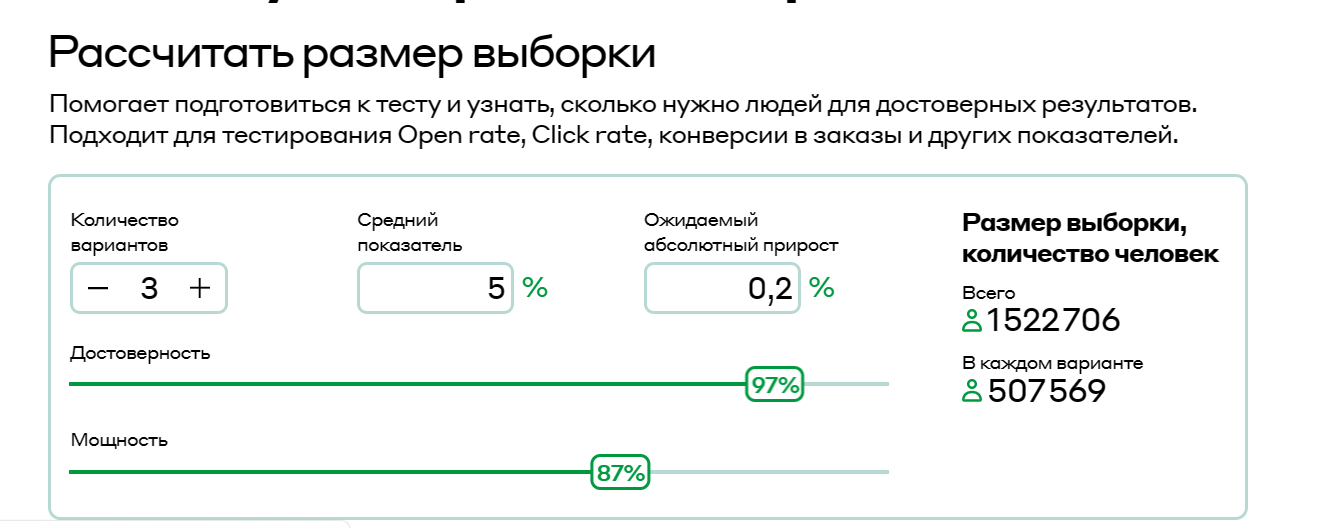

Общее нужно количество пользователей 1 522 706, за месяц у нас 40 000 пользователей, то есть для проведения теста с заданнами параметрами нам нужно 1 522 706/40 000 = 39 месяцев.
Скорее всего, у нас нет столько времени, поэтому можно рассмотреть возможность уменьшить уровень доверия до %95, и/или мощность до 80%, и/или уменьшить количество источников трафика до 2, и/или постараться увеличить количество пользователей продукта.

3.2) Допустим в задаче нет проблемы с количеством посетителей на сайт, тогда подведите 
результаты тестирования, если у нас следующие результаты по количеству конверсии (считаю это количеством конверсий за месяц):
1) 25 000 
2) 30 000
3) 32 000

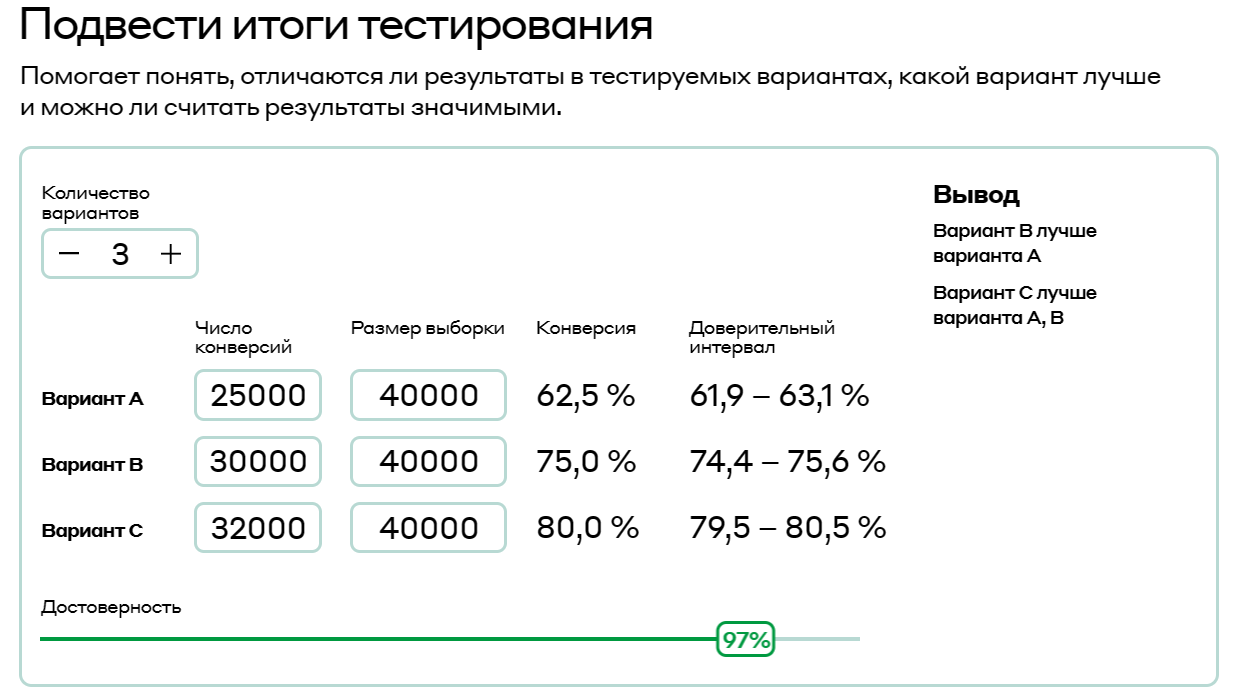

## 4) Вы решили сравнивать метрику CPA в двух группах. 
Размер выборки - 2350 элементов в каждой группе. 
Для проверки нормальности распределения на выборке в 2350 наблюдений применили , 
критерий Шапиро-Уилка и получили p-value, равный 0.00002, alpha = 5%.
Какой бы вывод мы могли сделать в данном случае?
В этом случае какой статистический критерий для проверки первоначальной гипотезы тут лучше 
всего подойдёт и почему ?

В данном случае применение критерия Шапиро-Уилка я бы поставила под сомнение, так как основным условие его использования является небольшой размер выборки. Поэтому полученные в результате теста данные, прежде чем интерпретировать, я бы проверила критерием Колмагорова-Смирнова, графиками QQplot и гистограммой. Если бы эти методы подтвердили полученные результаты, я бы сделала вывод о ненормальном распределении данных.

Так как CPA (англ. Сost per action — цена за действие) является количественной, имеет ненормальное распределение, выборки считаем независимыми, и их две - для проверки гипотезы о статистической значимости различий используем критерий Манна Уитни. Еще есть вариант применить метод бутстрапа.

## 5) Мы провели АБ-тест на увеличение average timespent per user. 
По итогам тестирования мы получили следующие данные. Является ли результат статистически значимым с уровнем доверия 80%? Какую версию мы выкатим на продакшн?
A) Средняя - 360, отклонение - 40, количество - 9802
B) Средняя - 352, отклонение - 58, количество - 9789


Так как average timespent per user является количественной, имеет нормальное распределение, выборки считаем независимыми, и их две - для проверки гипотезы о статистической значимости различий используем t критерий Стьюдента. Воспользуемся калькулятором:
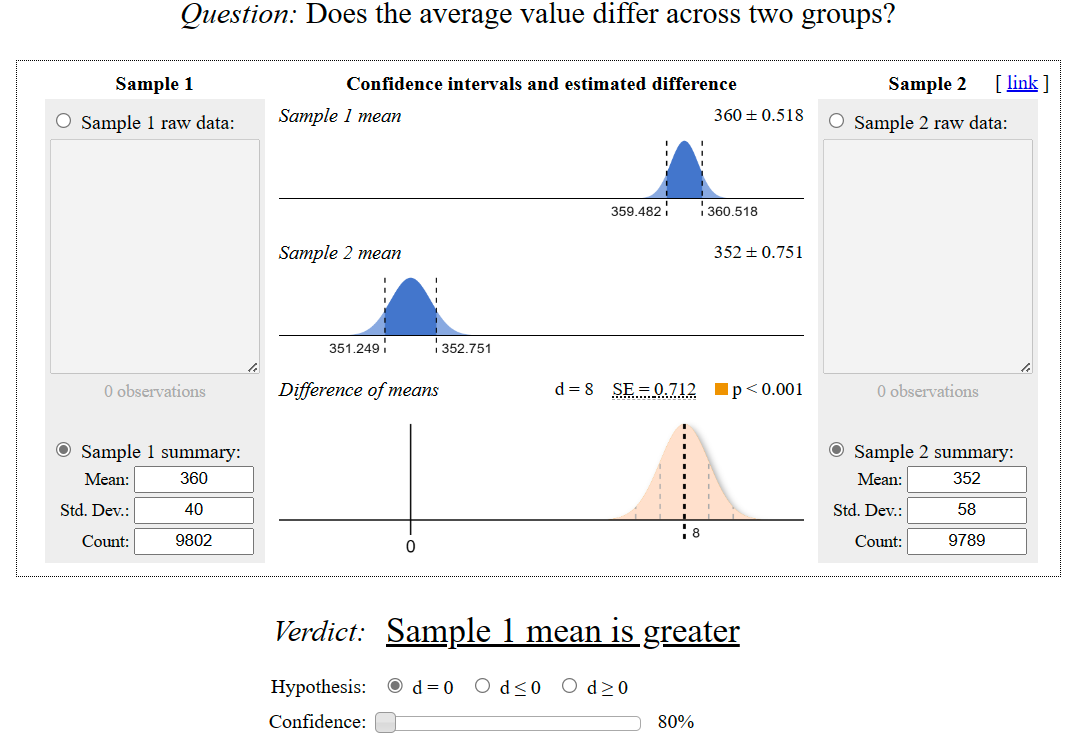

он дает нам ответ о том, что первая группа имеет статистически значимое большее среднее. Проверим этот результат:

In [162]:
mean_A = 360
mean_B = 352
std_A = 40
std_B = 58
t_observed=(mean_A - mean_B)/(std_A**2/9802 + std_B ** 2/9789)**0.5
print(f'Наблюдаемый критерий Стьюдента: {t_observed}')

Наблюдаемый критерий Стьюдента: 11.236630785707332


In [169]:
print(f'Табличный критерий Стьюдента: {t.ppf(0.975, 9802+9789-2)}')

Табличный критерий Стьюдента: 1.960085094107814


Так как модуль наблюдаемого критерия Стьюдента больше табличного, то мы принимаем альтернативнут гипотезу о неравестве средних значений с уровнем значимости 5%. результаты совпали.

## 6) Создайте техническую архитектуру проекта по аб тестированию продукта он-лайн кинотеатра с учетом кросс-девайс аналитики по следующей гипотезе:
Если договориться с банком о 99% кэшбэке на подписку первого месяца, то это повысит 
конверсию в подписку на 30%, благодаря упрощенному принятию решения со стороны 
пользователя.
На схеме необходимо отобразить:
1) Управленческий процесс по договоренностям с внешними партнерами
2) Архитектуру данных с указанием систем, из которых будем скачивать данные
3) Внутрикомандное взаимодействие

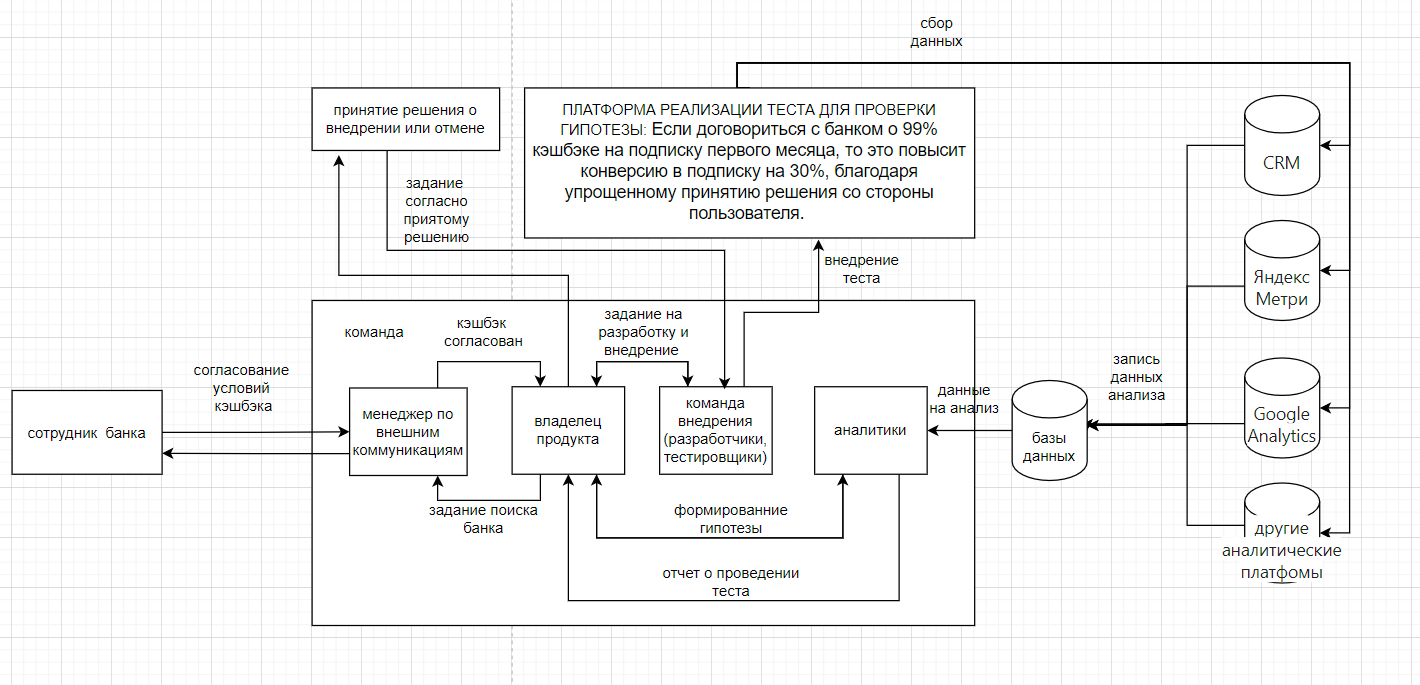